In [0]:
import os
import cv2
import time
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

train_batch_size = 128

In [0]:
%%capture
if not os.path.isdir('VOCdevkit/VOC2012/JPEGImages/'):
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
    !tar -xvf 'VOCtrainval_11-May-2012.tar'
    !sudo rm -r 'VOCtrainval_11-May-2012.tar'

In [0]:
class dataset_generator(Dataset):

    def make_label(self, top_array, bottom_array):        
        split = []
        for array in [top_array, bottom_array]:
            for i in range(len(array)):
                item = self.CHAR.find(array[i])
                split.append(item) 
        return np.asarray(split)
    
    def __init__(self, transforms):
        
        self.transforms = transforms
        self.image_filenames = []

        for filename in os.listdir('VOCdevkit/VOC2012/JPEGImages/'):
            self.image_filenames.append(os.path.join('VOCdevkit/VOC2012/JPEGImages/',filename))

        self.DIGITS = "0123456789"
        self.LETTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        self.CHAR = self.LETTERS + self.DIGITS
    
    # You must override __getitem__ and __len__
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self,index):

        self.font = random.choice([0,2,3,4])
        self.text_color = (random.randrange(0,100),random.randrange(0,100),random.randrange(0,100))
        self.text_thickness = random.randrange(10,16)

        self.plate_color = (random.randrange(200,255),random.randrange(200,255),random.randrange(200,255))

        self.upper_text = "{}{}{}{}{}".format(
            random.choice(self.LETTERS),
            random.choice(self.LETTERS),
            random.choice(self.DIGITS),
            random.choice(self.DIGITS),
            random.choice(self.DIGITS))

        self.lower_text = "{}{}{}{}{}".format(
            random.choice(self.LETTERS),
            random.choice(self.DIGITS),
            random.choice(self.DIGITS),
            random.choice(self.DIGITS),
            random.choice(self.DIGITS))
        
        self.label = self.make_label(self.upper_text, self.lower_text)
        
        self.pts1 = np.float32([[0,0],[530,0],[0,298],[530,298]])

        self.pts2 = np.float32([[random.randrange(0,100),random.randrange(0,60)],
                   [random.randrange(450,530),random.randrange(0,60)],
                   [random.randrange(0,100),random.randrange(270,298)],
                   [random.randrange(450,530),random.randrange(270,298)]])

        self.image = cv2.imread(self.image_filenames[index],1)
        self.image = cv2.resize(self.image,(128,64))

        blank_img = np.zeros((298,530,3), np.uint8)
        
        blank_img[:,:,0] = self.plate_color[0]
        blank_img[:,:,1] = self.plate_color[1]
        blank_img[:,:,2] = self.plate_color[2]

        cv2.putText(blank_img,self.upper_text,(70,125), self.font, 4,self.text_color,self.text_thickness,cv2.LINE_AA)
        cv2.putText(blank_img,self.lower_text,(70,255), self.font, 4,self.text_color,self.text_thickness,cv2.LINE_AA)

        M = cv2.getPerspectiveTransform(self.pts1,self.pts2)
        lp = cv2.warpPerspective(blank_img,M,(530,298))


        lp = cv2.resize(lp,(random.randrange(70,80),random.randrange(50,60)))

        p1 = (random.randrange(0,self.image.shape[0]-lp.shape[0]),random.randrange(0,self.image.shape[1]-lp.shape[1]))

        gray_lisence = cv2.cvtColor(lp,cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(gray_lisence, 2, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)

        bg = cv2.bitwise_and(self.image[p1[0]:p1[0]+lp.shape[0], p1[1]:p1[1]+lp.shape[1]],self.image[p1[0]:p1[0]+lp.shape[0], p1[1]:p1[1]+lp.shape[1]],mask = mask_inv)

        self.image[p1[0]:p1[0]+lp.shape[0], p1[1]:p1[1]+lp.shape[1]] = bg + lp
        self.image = cv2.cvtColor(self.image,cv2.COLOR_BGR2GRAY)

        self.image = Image.fromarray(self.image)   # Must be in PIL image format for transformations
        self.image = self.transforms(self.image)  
        return self.image, self.label

In [0]:
image_transforms = transforms.Compose([
        transforms.ColorJitter(brightness=1, contrast=0.2, saturation=0.3, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])

train_dataset = dataset_generator(image_transforms)

[17 11 34 35 30 14 30 34 33 33]


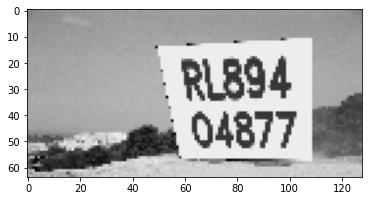

In [5]:
img, label = train_dataset[9]
plt.imshow(img.squeeze(0), cmap = 'gray')
print(label)

In [6]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(train_dataset))
len_test_set = int(0.1*len(train_dataset))
len_train_set = len(train_dataset) - len_valid_set - len_test_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))


train_dataset , valid_dataset , test_dataset = torch.utils.data.random_split(train_dataset, [len_train_set, len_valid_set, len_test_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle=True)

images, labels = next(iter(train_loader))

print(images.shape)
print(labels.shape)

The length of Train set is 13701
The length of Valid set is 1712
The length of Test set is 1712
torch.Size([128, 1, 64, 128])
torch.Size([128, 10])


In [7]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 48, kernel_size=5, padding = 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.5)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(48, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.5)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.5)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.5)
        )

        self.dense = nn.Sequential(
            nn.Linear(256 * 6 * 2, 2048),
            nn.ReLU(),
            # nn.Dropout(0.5),

            nn.Linear(2048, 360)
        )
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)

        x = x.view(x.size(dim = 0), -1) # flatten
        x = self.dense(x)

        out = torch.zeros([train_batch_size,10,36])

        for i in range(10):
            out[:,i,:] = F.softmax(x[:,i*36:(i+1)*36])
        return out
    
network = Network() 
network.cuda()
print(network)

Network(
  (conv_block1): Sequential(
    (0): Conv2d(1, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=3072, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=360, bias=True)
  )
)


In [8]:
images, labels = next(iter(train_loader))
images = images.cuda()
labels = labels.cuda()

logits = network(images)
logits = logits.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [9]:
print(logits.shape)
print(labels.shape)

torch.Size([128, 10, 36])
torch.Size([128, 10])


In [10]:
torch.sum(logits, dim=2).shape

torch.Size([128, 10])

In [0]:
import sys

def print_overwrite(step, total_step, loss, mean_iou, operation):
    sys.stdout.write('\r')
    
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f  Accuracy: %.4f" % (step, total_step, loss, mean_iou))
        
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f  Accuracy: %.4f" % (step, total_step, loss, mean_iou))
        
    sys.stdout.flush()

In [0]:
num_epochs = 500
acc_max = 0

train_loss_history = []
valid_loss_history = []
train_acc_history = []
valid_acc_history = []

# function to find the accuracy
def find_acc(pred, label):
    correct = pred.argmax(dim = 2).eq(label)
    accuracy = correct.to(torch.float32).mean().item()
    return accuracy * 100 

# loss defined using torch.nn
criterion = nn.CrossEntropyLoss()

# define the optimizer
# only weights of fc layer has to be updated
optimizer = optim.Adam(network.parameters(), lr=0.001)

# note the starting time to find the total time elapsed
start_time = time.time()

for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    acc_train = 0
    acc_valid = 0
    running_loss = 0
    running_acc = 0
    
    # set the network into train mode
    network.train()
    
    for step in range(1,len(train_loader)+1):
    
        images, labels = next(iter(train_loader))
        
        # move the images and labels to GPU
        images = images.cuda()
        labels = labels.cuda()
        
        logits = network(images)
        logits = logits.cuda()
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()

        loss_train_char = torch.zeros([10])

        # find the loss and acc for the current step
        for i in range(10):
            loss_train_char[i] = criterion(logits[:,i,:], labels[:,i])

        loss_train_step = torch.mean(loss_train_char)
        acc_train_step = find_acc(logits, labels)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        acc_train += acc_train_step 
        running_loss = loss_train/step
        running_accuracy = acc_train/step

        print_overwrite(step, len(train_loader), running_loss, running_accuracy, 'train')
        
    network.eval() 
    
    # turn the gradients off for validation
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, labels = next(iter(valid_loader))

            # move the images and labels to GPU
            images = images.cuda()
            labels = labels.cuda()

            logits = network(images)
            logits = logits.cuda()

            # clear all the gradients before calculating them
            optimizer.zero_grad()

            loss_valid_char = torch.zeros([10])

            # find the loss and acc for the current step
            for i in range(10):
                loss_valid_char[i] = criterion(logits[:,i,:], labels[:,i])

            loss_valid_step = torch.mean(loss_valid_char)
            acc_valid_step = find_acc(logits, labels)

            loss_valid += loss_valid_step.item()
            acc_valid += acc_valid_step
            running_loss = loss_valid/step
            running_accuracy = acc_valid/step
            print_overwrite(step, len(valid_loader), running_loss, running_accuracy, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    acc_train /= len(train_loader)
    acc_valid /= len(valid_loader)

    train_loss_history.append(loss_train)
    valid_loss_history.append(loss_valid)
    train_acc_history.append(acc_train)
    valid_acc_history.append(acc_valid)
    
    print('\n------------------------------------------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))
    
    if acc_valid > acc_max:
        acc_max = acc_valid
        torch.save(network.state_dict(), 'midas_cv_task.pth') 
        print("\nMaximum validation acc: {:.2f} % at epoch {}/{}".format(acc_max, epoch, num_epochs))
        print('Model Saved\n')
    
# find the time at the end of training    
end_time = time.time()

print('Training Complete')
print("Total time taken : {} s".format(end_time - start_time))

Train Steps: 1/108  Loss: 3.5835  Accuracy: 3.0469

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Valid Steps: 14/14  Loss: 3.5476  Accuracy: 8.2589
------------------------------------------------------------------------------------
Epoch: 1  Train Loss: 3.5494  Train Acc: 8.0490  Valid Loss: 3.5476  Valid Acc: 8.2589

Maximum validation acc: 8.26 % at epoch 1/500
Model Saved

Valid Steps: 14/14  Loss: 3.5508  Accuracy: 7.9353
------------------------------------------------------------------------------------
Epoch: 2  Train Loss: 3.5488  Train Acc: 8.1359  Valid Loss: 3.5508  Valid Acc: 7.9353
Valid Steps: 14/14  Loss: 3.5481  Accuracy: 8.2031
------------------------------------------------------------------------------------
Epoch: 3  Train Loss: 3.5478  Train Acc: 8.2328  Valid Loss: 3.5481  Valid Acc: 8.2031
Valid Steps: 14/14  Loss: 3.5453  Accuracy: 8.4821
------------------------------------------------------------------------------------
Epoch: 4  Train Loss: 3.5479  Train Acc: 8.2205  Valid Loss: 3.5453  Valid Acc: 8.4821

Maximum validation acc: 8.48 % at epoch 4/500
M

In [0]:
img, label = test_dataset[120]
image = torch.tensor(img).unsqueeze(0).cuda()
label = torch.tensor(label).cuda()

logit = network(image)

plt.imshow(img.squeeze(0), cmap = 'gray')
print(label)
print(logit.squeeze(0).argmax(dim = 2)[0])

In [0]:
print(logit.shape)